In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Mahony.MahonyAHRS as MAHRS
from ximu_python_library import xIMUdataClass as xIMU

In [75]:
def length(array: np.array) -> int:
    """
    Like a length() in Matlab.

    :param array: numpy array.
    :return: the length of the largest array dimension.
    """
    return max(array.shape)

In [121]:
def expo_filter(alpha, y_prev, x):
    y = (1 - alpha) * y_prev + alpha * x
    return y

In [76]:
recorded_data = pd.read_csv("logged_data/LoggedData_CalInertialAndMag.csv")

In [77]:
recorded_data

,packetNumb,gyrX,gyrY,gyrZ,accX,accY,accZ,magX,magY,magZ
0,0,-0.1250,-0.0625,0.1250,-0.028809,0.016602,1.017090,15.99951,15.99951,15.11475
1,2,-0.1250,-0.2500,0.0000,0.002441,-0.002441,0.973633,15.99951,15.99951,15.09375
2,4,-0.0625,-0.1875,0.0000,0.006348,0.016602,0.989258,15.99951,15.99951,15.09375
3,6,0.1250,0.0000,0.0000,-0.040527,0.032227,1.013184,15.99951,15.99951,15.09375
4,8,-0.1250,-0.1250,0.0000,-0.017090,-0.002441,0.997070,15.99951,15.99951,15.12012
...,...,...,...,...,...,...,...,...,...,...
11612,24223,-0.0625,-0.1250,-0.0625,0.018066,0.016602,0.997070,15.99951,15.99951,15.33057
11613,24225,0.0000,0.0000,0.0000,0.021973,0.004883,0.989258,15.99951,15.99951,15.33057
11614,24227,-0.0625,-0.1250,0.0625,-0.008789,-0.018066,0.973633,15.99951,15.99951,15.33057
11615,24229,-0.1250,-0.1250,0.0625,-0.032715,0.000977,1.017090,15.99951,15.99951,15.33594


In [78]:
data = recorded_data.copy()
data.loc[:, "gyrX":"gyrZ"] *= (np.pi/180)
data

,packetNumb,gyrX,gyrY,gyrZ,accX,accY,accZ,magX,magY,magZ
0,0,-0.002182,-0.001091,0.002182,-0.028809,0.016602,1.017090,15.99951,15.99951,15.11475
1,2,-0.002182,-0.004363,0.000000,0.002441,-0.002441,0.973633,15.99951,15.99951,15.09375
2,4,-0.001091,-0.003272,0.000000,0.006348,0.016602,0.989258,15.99951,15.99951,15.09375
3,6,0.002182,0.000000,0.000000,-0.040527,0.032227,1.013184,15.99951,15.99951,15.09375
4,8,-0.002182,-0.002182,0.000000,-0.017090,-0.002441,0.997070,15.99951,15.99951,15.12012
...,...,...,...,...,...,...,...,...,...,...
11612,24223,-0.001091,-0.002182,-0.001091,0.018066,0.016602,0.997070,15.99951,15.99951,15.33057
11613,24225,0.000000,0.000000,0.000000,0.021973,0.004883,0.989258,15.99951,15.99951,15.33057
11614,24227,-0.001091,-0.002182,0.001091,-0.008789,-0.018066,0.973633,15.99951,15.99951,15.33057
11615,24229,-0.002182,-0.002182,0.001091,-0.032715,0.000977,1.017090,15.99951,15.99951,15.33594


In [79]:
sample_frequency = 256
sample_period = 1 / sample_frequency

In [80]:
ahrs = MAHRS.Mahony(sample_frequency, 0, 0)

In [81]:
gyr = data.loc[:, "gyrX":"gyrZ"].to_numpy()
acc = data.loc[:, "accX":"accZ"].to_numpy()
x_time = data.loc[:, "packetNumb"].to_numpy()

In [82]:
array_len = data.gyrX.size

In [83]:
R = np.zeros((3, 3, data.size))

In [84]:
for i in range(array_len):
    ahrs.update_imu(gyr[i], acc[i])
    R[:, :, i] = ahrs.Q_to_DCM()


In [85]:
# Calculate 'tilt-compensated' accelerometer
tc_acc = np.zeros(acc.shape)  # accelerometer in Earth frame

for i in range(array_len):
    tc_acc[i, :] = R[:, :, i] @ acc[i, :]

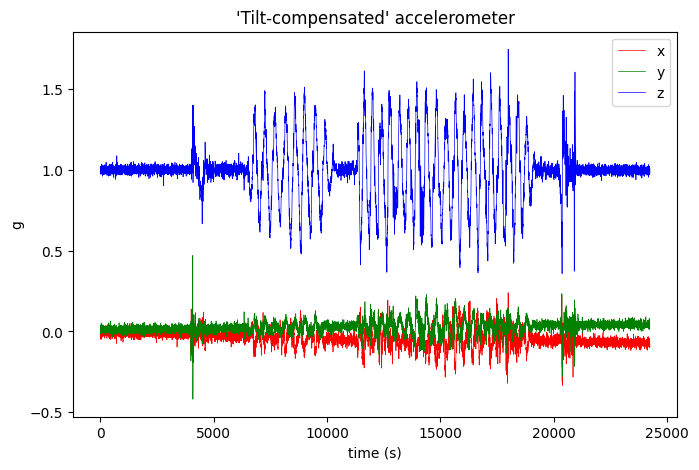

In [86]:
fig = plt.figure(figsize=(7.8, 5))
plt.plot(x_time, tc_acc[:, 0], c='r', linewidth=0.5)
plt.plot(x_time, tc_acc[:, 1], c='g', linewidth=0.5)
plt.plot(x_time, tc_acc[:, 2], c='b', linewidth=0.5)
plt.legend(["x", "y", "z"])
plt.title("'Tilt-compensated' accelerometer")
plt.xlabel("time (s)")
plt.ylabel("g")
plt.show(block=False)

In [87]:
lin_acc = tc_acc - np.array([np.zeros(length(tc_acc)),
                             np.zeros(length(tc_acc)),
                             np.ones(length(tc_acc))]).T

lin_acc *= 9.81  # convert from 'g' to m/s^2

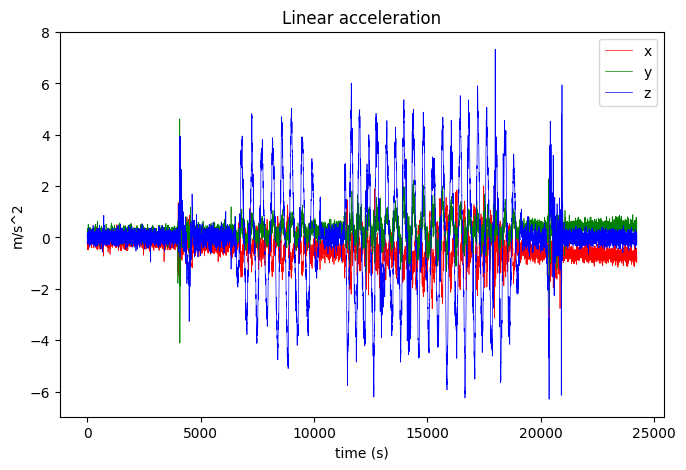

In [88]:
fig = plt.figure(figsize=(7.8, 5))
plt.plot(x_time, lin_acc[:, 0], c='r', linewidth=0.5)
plt.plot(x_time, lin_acc[:, 1], c='g', linewidth=0.5)
plt.plot(x_time, lin_acc[:, 2], c='b', linewidth=0.5)
plt.legend(["x", "y", "z"])
plt.title("Linear acceleration")
plt.xlabel("time (s)")
plt.ylabel("m/s^2")
plt.show(block=False)

In [127]:
filtered_acc_x_prev = 0
filtered_acc_y_prev = 0
filtered_acc_z_prev = 0

filtered_acc_x = np.zeros(array_len, dtype=np.float64)
filtered_acc_y = np.zeros(array_len, dtype=np.float64)
filtered_acc_z = np.zeros(array_len, dtype=np.float64)
alpha = 0.001

for i in range(array_len):
    filtered_acc_x[i] = expo_filter(alpha, filtered_acc_x_prev, lin_acc[i, 0])
    filtered_acc_y[i] = expo_filter(alpha, filtered_acc_y_prev, lin_acc[i, 1])
    filtered_acc_z[i] = expo_filter(alpha, filtered_acc_z_prev, lin_acc[i, 2])
    filtered_acc_x_prev = filtered_acc_x[i]
    filtered_acc_y_prev = filtered_acc_y[i]
    filtered_acc_z_prev = filtered_acc_z[i]

filtered_acc_x

array([-2.82656172e-04, -2.58626613e-04, -1.96429686e-04, ...,
       -6.38109606e-01, -6.38450807e-01, -6.38595855e-01])

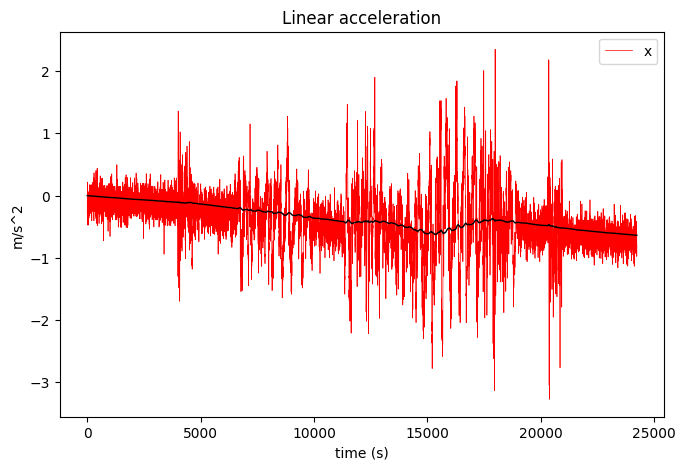

In [128]:
fig = plt.figure(figsize=(7.8, 5))
plt.plot(x_time, lin_acc[:, 0], c='r', linewidth=0.5)
plt.plot(x_time, filtered_acc_x, c='black', linewidth=1)
plt.legend(["x"])
plt.title("Linear acceleration")
plt.xlabel("time (s)")
plt.ylabel("m/s^2")
plt.show(block=False)

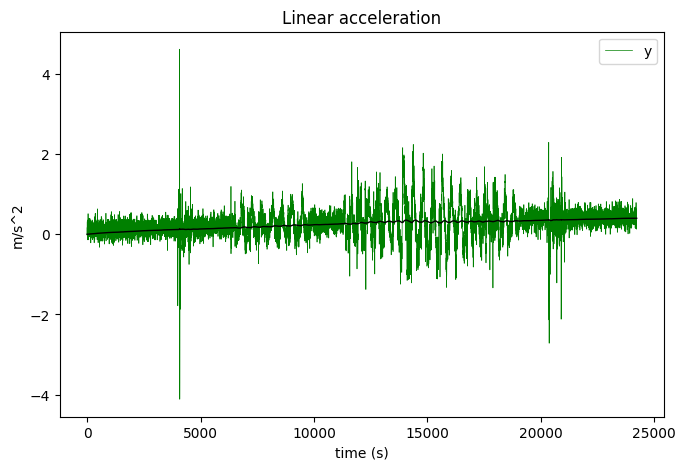

In [129]:
fig = plt.figure(figsize=(7.8, 5))
plt.plot(x_time, lin_acc[:, 1], c='g', linewidth=0.5)
plt.plot(x_time, filtered_acc_y, c='black', linewidth=1)
plt.legend(["y"])
plt.title("Linear acceleration")
plt.xlabel("time (s)")
plt.ylabel("m/s^2")
plt.show(block=False)

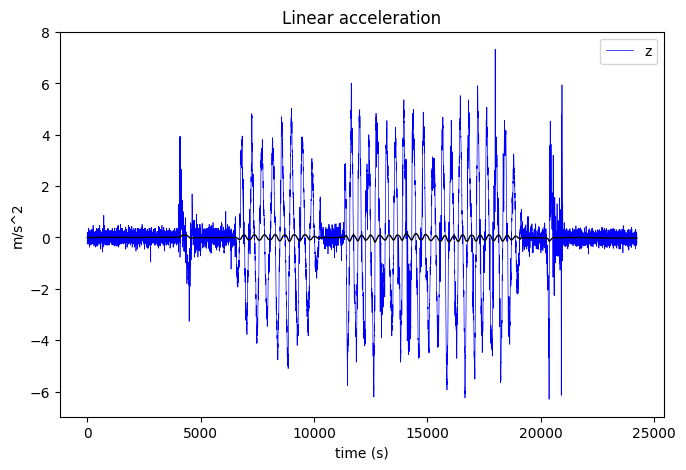

In [130]:
fig = plt.figure(figsize=(7.8, 5))
plt.plot(x_time, lin_acc[:, 2], c='b', linewidth=0.5)
plt.plot(x_time, filtered_acc_z, c='black', linewidth=1)
plt.legend(["z"])
plt.title("Linear acceleration")
plt.xlabel("time (s)")
plt.ylabel("m/s^2")
plt.show(block=False)